# MadMiner particle physics tutorial

# Part 4a: Limit setting

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In part 4a of this tutorial we will use the networks trained in step 3a and 3b to calculate the expected limits on our theory parameters.

## Preparations

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import six
import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.limits import AsymptoticLimits
from madminer.sampling import SampleAugmenter
from madminer import sampling


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Preparations

In the end, what we care about are not plots of the log likelihood ratio, but limits on parameters. But at least under some asymptotic assumptions, these are directly related. MadMiner makes it easy to calculate p-values in the asymptotic limit with the `AsymptoticLimits` class in the `madminer.limits`: 

In [3]:
limits = AsymptoticLimits('data/lhe_data_shuffled.h5')
# limits = AsymptoticLimits('data/delphes_data_shuffled.h5')

14:25 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
14:25 madminer.analysis    INFO    Found 2 parameters
14:25 madminer.analysis    INFO    Did not find nuisance parameters
14:25 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
14:25 madminer.analysis    INFO    Found 3 observables
14:25 madminer.analysis    INFO    Found 14839 events
14:25 madminer.analysis    INFO    Found morphing setup with 6 components


This class provids two high-level functions:
- `AsymptoticLimits.observed_limits()` lets us calculate p-values on a parameter grid for some observed events, and
- `AsymptoticLimits.expected_limits()` lets us calculate expected p-values on a parameter grid based on all data in the MadMiner file.

First we have to define the parameter grid on which we evaluate the p-values.

In [4]:
theta_ranges = [(-20., 20.), (-20., 20.)]
resolutions = [25, 25]

In [5]:
lumi = 3000.

In [6]:
p_values = {}
mle = {}

## 2. Expected limits based on rate or simple histograms

First, with `mode="rate"`, we can calculate expected limits based only on rate information:

In [7]:
_, p_values_expected_xsec, best_fit_expected_xsec = limits.expected_limits(
    mode="rate",
    theta_true=[0.,0.],
    theta_ranges=theta_ranges,
    resolutions=resolutions,
    luminosity=1.
)

p_values["Rate"] = p_values_expected_xsec
mle["Rate"] = best_fit_expected_xsec

14:25 madminer.limits      INFO    Calculating rate log likelihood
14:25 madminer.limits      INFO    Calculating p-values


Withoout backgrounds and systematics, the rate would let us measure the Wilson coefficients extremely precisely -- so to see something interesting in this tutorial, we artificially reduce the luminosity in the rate curve and don't include rate information in all other methods.

`mode="histo"` calculates limits based on histograms. For now, there is not a lot of freedom in this step, the histogram binning is determined automatically.

In [8]:
limits.expected_limits?

In [9]:
_, p_values_expected_histo, best_fit_expected_histo = limits.expected_limits(
    mode="histo",
    hist_vars=["pt_j1"],
    theta_true=[0.,0.],
    theta_ranges=theta_ranges,
    resolutions=resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["$p_T(j)$"] = p_values_expected_histo
mle["$p_T(j)$"] = best_fit_expected_histo

14:25 madminer.limits      INFO    Setting up standard summary statistics
14:25 madminer.limits      INFO    Creating histogram with 20 bins for the summary statistics
14:25 madminer.limits      INFO    Building histogram with %s bins per parameter and %s bins per observable
14:25 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
14:25 madminer.analysis    INFO    Found 2 parameters
14:25 madminer.analysis    INFO    Did not find nuisance parameters
14:25 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
14:25 madminer.analysis    INFO    Found 3 observables
14:25 madminer.analysis    INFO    Found 14839 events
14:25 madminer.analysis    INFO    Found morphing setup with 6 components
14:25 madminer.sampling    INFO    Extracting plain training sample. Sampling according to 625 morphing points, starting with [array([-20., -20.]), array([-18.33333333, -20.        ]), array([-16.66666667, -20.        ])]
14:25 madminer.sampling    INFO    Starting

## 3. Expected limits based on ratio estimators

Finally and perhaps most importantly, `mode="ml"` allows us to calculate limits based on any `ParamterizedRatioEstimator` instance like the ALICES estimator trained above:

In [10]:
theta_grid, p_values_expected_alices, best_fit_expected_alices = limits.expected_limits(
    mode="ml",
    model_file='models/alices',
    theta_true=[0.,0.],
    theta_ranges=theta_ranges,
    resolutions=resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["ALICES"] = p_values_expected_alices
mle["ALICES"] = best_fit_expected_alices

14:25 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
14:25 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
14:25 madminer.limits      INFO    Calculating p-values


## 4. Expected limits based on score estimators

In [11]:
theta_grid, p_values_expected_sally, best_fit_expected_sally = limits.expected_limits(
    mode="histo",
    model_file='models/sally',
    theta_true=[0.,0.],
    theta_ranges=theta_ranges,
    resolutions=resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["SALLY"] = p_values_expected_sally
mle["SALLY"] = best_fit_expected_sally

14:25 madminer.limits      INFO    Loading score estimator and setting it up as summary statistics
14:25 madminer.limits      INFO    Creating histogram with 20 bins for the summary statistics
14:25 madminer.limits      INFO    Building histogram with %s bins per parameter and %s bins per observable
14:25 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
14:25 madminer.analysis    INFO    Found 2 parameters
14:25 madminer.analysis    INFO    Did not find nuisance parameters
14:25 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
14:25 madminer.analysis    INFO    Found 3 observables
14:25 madminer.analysis    INFO    Found 14839 events
14:25 madminer.analysis    INFO    Found morphing setup with 6 components
14:25 madminer.sampling    INFO    Extracting plain training sample. Sampling according to 625 morphing points, starting with [array([-20., -20.]), array([-18.33333333, -20.        ]), array([-16.66666667, -20.        ])]
14:25 madminer.sam

## 5. Toy signal

Observed limits take as input actual data, which we here generate on the fly:

In [12]:
sampler = SampleAugmenter('data/lhe_data_shuffled.h5')
x_observed, _, _ = sampler.sample_test(
    theta=sampling.morphing_point([5.,5.]),
    n_samples=5,
    folder=None,
    filename=None,
)

14:26 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
14:26 madminer.analysis    INFO    Found 2 parameters
14:26 madminer.analysis    INFO    Did not find nuisance parameters
14:26 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
14:26 madminer.analysis    INFO    Found 3 observables
14:26 madminer.analysis    INFO    Found 14839 events
14:26 madminer.analysis    INFO    Found morphing setup with 6 components
14:26 madminer.sampling    INFO    Extracting evaluation sample. Sampling according to [5. 5.]
14:26 madminer.sampling    INFO    Starting sampling serially
14:26 madminer.sampling    INFO    Sampling from parameter point 1 / 1
14:26 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [5. 5.]: (0.002524 +/- 0.000353) pb (13.98837508579752 %). Skipping these warnings in the future...
14:26 madminer.sampling    INFO    Effective number of samples: 9.355568335724028


In [13]:
_, p_values_observed, best_fit_observed = limits.observed_limits(
    x_observed=x_observed,
    mode="ml",
    model_file='models/alices',
    theta_ranges=theta_ranges,
    resolutions=resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["ALICES signal"] = p_values_observed
mle["ALICES signal"] = best_fit_observed

14:26 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
14:26 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
14:26 madminer.limits      INFO    Calculating p-values


## 6. Plot

Let's plot the results:

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


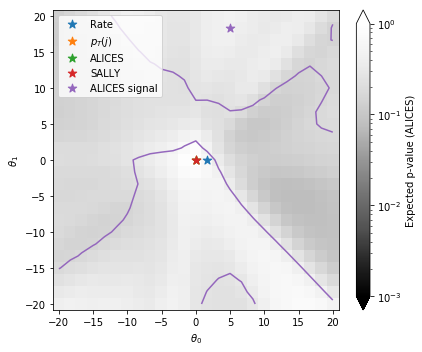

In [14]:
show = "ALICES"

bin_size = (theta_ranges[0][1] - theta_ranges[0][0])/(resolutions[0] - 1)
edges = np.linspace(theta_ranges[0][0] - bin_size/2, theta_ranges[0][1] + bin_size/2, resolutions[0] + 1)
centers = np.linspace(theta_ranges[0][0], theta_ranges[0][1], resolutions[0])

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

cmin, cmax = 1.e-3, 1.

pcm = ax.pcolormesh(
    edges, edges, p_values[show].reshape((resolutions[0], resolutions[1])),
    norm=matplotlib.colors.LogNorm(vmin=cmin, vmax=cmax),
    cmap='Greys_r'
)
cbar = fig.colorbar(pcm, ax=ax, extend='both')

for i, (label, p_value) in enumerate(six.iteritems(p_values)):
    plt.contour(
        centers, centers, p_value.reshape((resolutions[0], resolutions[1])),
        levels=[0.05],
        linestyles='-', colors='C{}'.format(i)
    )
    plt.scatter(
        theta_grid[mle[label]][0], theta_grid[mle[label]][1],
        s=80., color='C{}'.format(i), marker='*',
        label=label
    )

plt.legend()

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label('Expected p-value ({})'.format(show))

plt.tight_layout()
plt.show()
